In [1]:
library(tidyverse)
library(cowplot)
library(ggExtra)
library(ggbeeswarm)
library(ggrepel)

`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



## Calibration curves

In [2]:
full_cal_bins <- read_csv('../../data/task1/calibration/hetionet_calibration_bins.csv')
sampled_cal_bins <- read_csv('../../data/task1/calibration/hetionet_calibration_bins_sampled.csv')

Parsed with column specification:
cols(
  expected_frac = col_double(),
  lower_ci = col_double(),
  upper_ci = col_double(),
  feature = col_character(),
  feature_value = col_double(),
  metaedge = col_character()
)
Parsed with column specification:
cols(
  expected_frac = col_double(),
  lower_ci = col_double(),
  upper_ci = col_double(),
  feature = col_character(),
  feature_value = col_double(),
  metaedge = col_character()
)


In [3]:
full_cal_bins <- full_cal_bins %>%
    mutate(feature = feature %>% recode_factor(scaled_degree = 'Scaled degree',
                                               analytic_prior = 'Approximate prior',
                                               xswap_prior = 'Edge prior'))

sampled_cal_bins <- sampled_cal_bins %>%
    mutate(feature = feature %>% recode_factor(scaled_degree = 'Scaled degree',
                                               analytic_prior = 'Approximate prior',
                                               xswap_prior = 'Edge prior'))

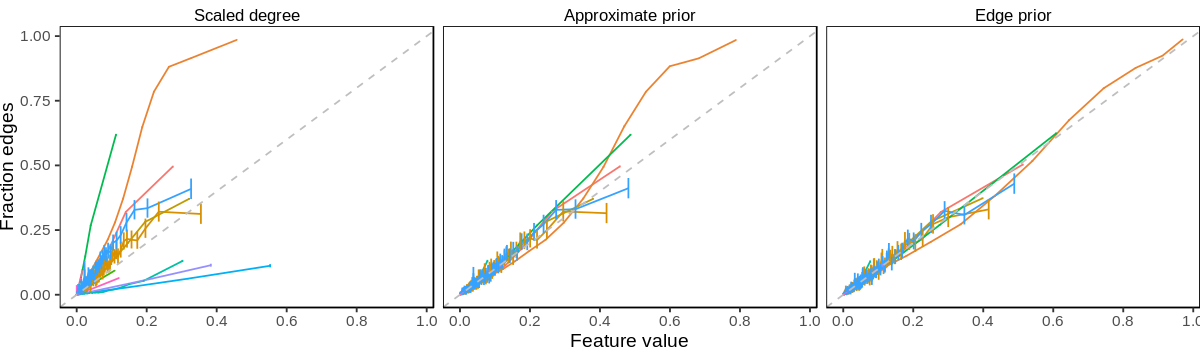

In [4]:
options(repr.plot.width=10, repr.plot.height=3)

full_calibration_plot <- (
    ggplot(full_cal_bins, aes(x = feature_value, y = expected_frac, ymin = lower_ci, 
                              ymax = upper_ci, color = metaedge))
    + geom_line()
    + geom_errorbar()
    + geom_abline(color = 'grey', linetype = 'dashed')
    + facet_wrap(vars(feature), nrow = 1)
    + theme_zietzm()
    + ylab('Fraction edges')
    + xlab('Feature value')
    + theme(legend.position = "none", plot.margin = unit(c(0.2, 0, 0.2, 0), "cm"))
    + scale_x_continuous(breaks = c(0, 0.2, 0.4, 0.6, 0.8, 1))
)

sampled_calibration_plot <- (
    ggplot(sampled_cal_bins, aes(x = feature_value, y = expected_frac, ymin = lower_ci, 
                              ymax = upper_ci, color = metaedge))
    + geom_line()
    + geom_errorbar()
    + geom_abline(color = 'grey', linetype = 'dashed')
    + facet_wrap(vars(feature),  nrow = 1)
    + theme_zietzm()
    + ylab('Fraction edges')
    + xlab('Feature value')
    + theme(legend.position = "none", plot.margin = unit(c(0.2, 0, 0.2, 0), "cm"))
)
    
full_calibration_plot

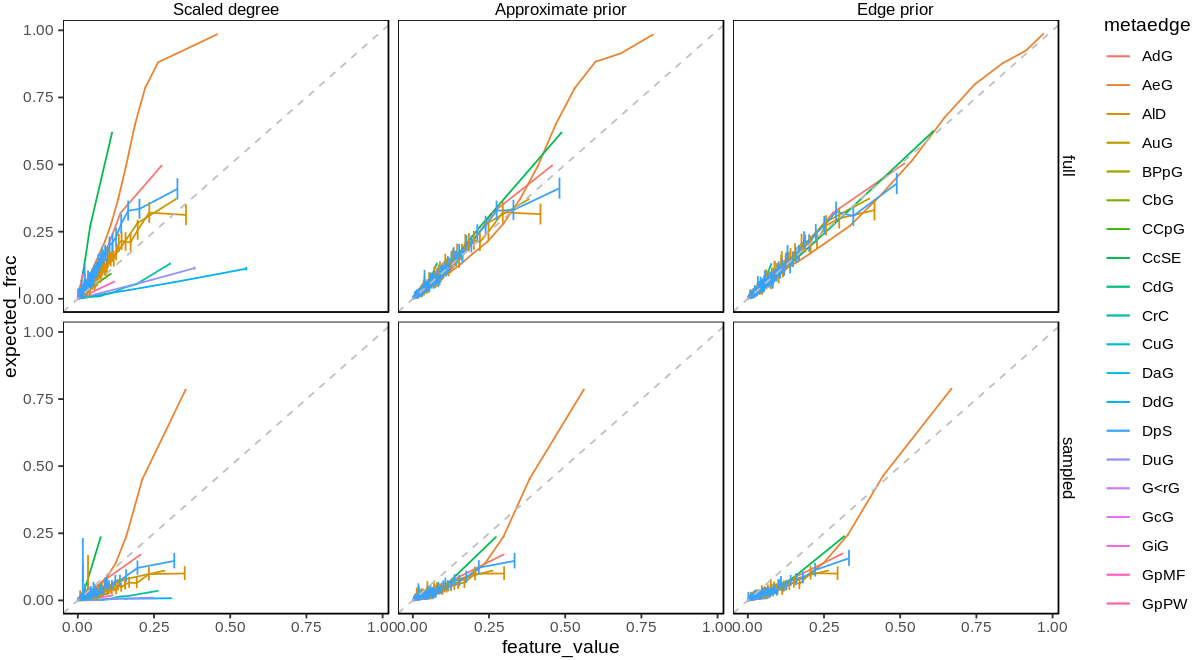

In [5]:
options(repr.plot.width=10, repr.plot.height=5.5)


calibration_plot <- bind_rows(
    full_cal_bins %>% mutate(network = 'full'),
    sampled_cal_bins %>% mutate(network = 'sampled')
) %>% 
# filter(metaedge == 'AeG') %>%
ggplot(aes(x = feature_value, y = expected_frac, ymin = lower_ci, 
                ymax = upper_ci, color = metaedge)) + 
geom_line() + 
geom_errorbar() + 
geom_abline(color = 'grey', linetype = 'dashed') + 
facet_grid(rows = vars(network), cols = vars(feature)) +
theme_zietzm()

calibration_plot

## Calibration metrics

In [6]:
metrics <- read_csv('../../data/task1/calibration/hetionet_calibration_metrics.csv') %>%
   mutate(
       network = network %>% recode_factor(full = 'Unsampled network', 
                                           sampled = 'Sampled network', 
                                           other = 'Separate network'),
       feature = feature %>% recode_factor(scaled_degree = 'scaled degree', 
                                           analytic_prior = 'approx',
                                           xswap_prior = 'edge prior'),
   )

metrics %>% head

Parsed with column specification:
cols(
  network = col_character(),
  metaedge = col_character(),
  feature = col_character(),
  cal = col_double(),
  ref = col_double(),
  brier = col_double(),
  weighted_mae = col_double(),
  auroc = col_double()
)


network,metaedge,feature,cal,ref,brier,weighted_mae,auroc
<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Unsampled network,AdG,edge prior,0.0005348332,0.007573513,0.008108346,0.3356053,0.9893918
Unsampled network,AdG,approx,0.0006444262,0.007571256,0.008215682,0.3512889,0.9891555
Unsampled network,AdG,scaled degree,0.0015091243,0.007574097,0.009083222,0.4140236,0.9891437
Unsampled network,AeG,edge prior,0.0011463458,0.018729566,0.019875912,0.1737322,0.9873503
Unsampled network,AeG,approx,0.0045910898,0.018719604,0.023310694,0.2541119,0.9868655
Unsampled network,AeG,scaled degree,0.0195552381,0.018735534,0.038290772,0.3850257,0.9868530


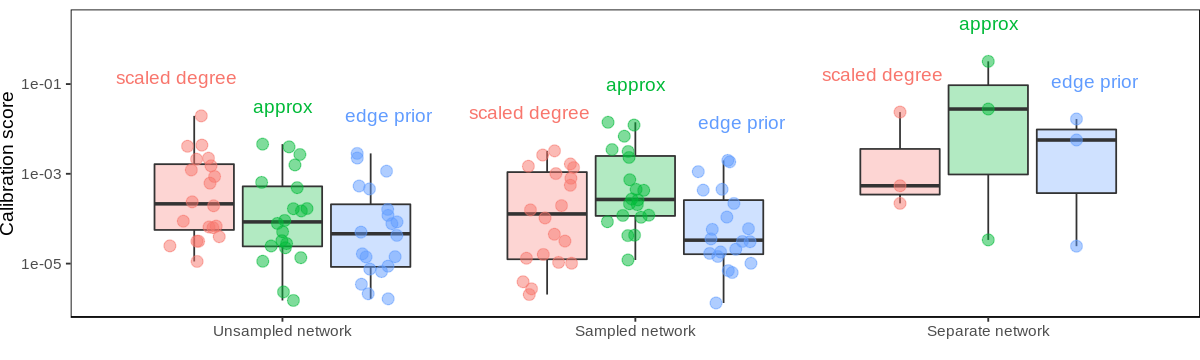

In [7]:
options(repr.plot.width=10, repr.plot.height=3)

labels_df <- metrics %>% 
    group_by(feature, network) %>% 
    top_n(cal, n = 1) %>%
    mutate(
#         y = 7e-2,
        y = 7 * cal,
#         y = 1.1 * cal
    )

cal_3 <- (
    ggplot(metrics, aes(x = network, y = cal))
    + geom_boxplot(aes(fill = feature), outlier.shape = NA, alpha = 0.3)
    # Only jitter points in the first two networks
    + geom_point(data = metrics %>% filter(network != 'Separate network'),
                 aes(color = feature, group = feature), alpha = 0.5, cex = 3,
                 position = position_jitterdodge(jitter.width = 0.4))
    # Don't jitter the "Separate network" points
    + geom_point(data = metrics %>% filter(network == 'Separate network'),
                 aes(color = feature, group = feature), alpha = 0.5, cex = 3,
                 position = position_dodge(width = 0.75))
    # Alternatively, use beeswarm
#     + geom_beeswarm(data = metrics, aes(color = feature, group = feature), 
#                     alpha = 0.5, cex = 2.3, dodge.width = 0.75, size = 3)

    + theme_zietzm()
#     + scale_y_log10()
    + scale_y_continuous(trans = 'log10')
    + theme(plot.margin = unit(c(0.2, 0, 0, 0), "cm"))
    + xlab("") 
    + ylab("Calibration score")
    + geom_text(data = labels_df, aes(x = network, y = y, color = feature, label = feature),
                position = position_dodge2(width = 0.9), size = 4)
    + theme(legend.position = 'none')
)

cal_3

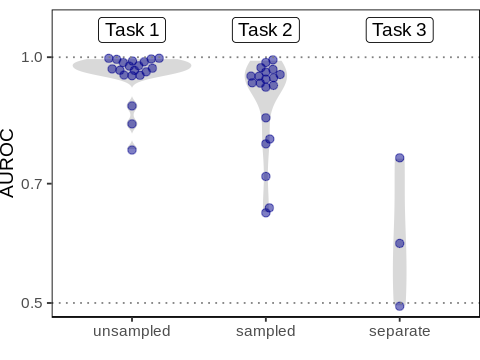

In [8]:
options(repr.plot.width=4, repr.plot.height=3)

labels_df <- metrics %>%
    filter(feature == 'edge prior') %>%
    group_by(network) %>% 
    top_n(auroc, n = 1) %>%
    ungroup() %>%
    mutate(
#         y = 1.1 * auroc,
        y = 1.08,
        label = network %>% recode_factor('Unsampled network' = 'Task 1',
                                          'Sampled network' = 'Task 2',
                                          'Separate network' = 'Task 3'),
        network = network %>% recode_factor('Unsampled network' = 'unsampled',
                                            'Sampled network' = 'sampled',
                                            'Separate network' = 'separate')
    )

auroc <- (
    ggplot(metrics %>% 
               filter(feature == 'edge prior') %>% 
               mutate(network = network %>% recode_factor('Unsampled network' = 'unsampled',
                                                          'Sampled network' = 'sampled',
                                                          'Separate network' = 'separate')), 
           aes(x = network, y = auroc))
#     + geom_boxplot(aes(fill = feature), outlier.shape = NA, alpha = 0.3)
    + geom_violin(data = metrics %>% 
#                       filter(feature == 'edge prior' & network != 'Separate network'), 
                      filter(feature == 'edge prior') %>% 
                      mutate(network = network %>% recode_factor('Unsampled network' = 'unsampled',
                                                                 'Sampled network' = 'sampled',
                                                                 'Separate network' = 'separate')), 
                  fill = 'grey85', color = 'white')
    + scale_x_discrete(limits = c('unsampled', 'sampled', 'separate'))
    + geom_beeswarm(alpha = 0.5, cex = 2, color = 'darkblue', size = 2)
    + theme_zietzm()
    + scale_y_log10()
    + theme(plot.margin = unit(c(0.2, 0, 0, 0), "cm"), legend.position = 'none')
    + xlab("") 
    + ylab("AUROC")
    + geom_label(data = labels_df, aes(x = network, y = y, label = label),
                 position = position_dodge2(width = 0.75), size = 4)
    + coord_cartesian(ylim = c(0.5, 1.1))
    + geom_hline(yintercept = 0.5, color = 'grey50', linetype = 'dotted')
    + geom_hline(yintercept = 1, color = 'grey50', linetype = 'dotted')
)

ggsave(filename = '../../img/auroc.png', auroc, dpi = 300, width = 4, height = 3)

auroc

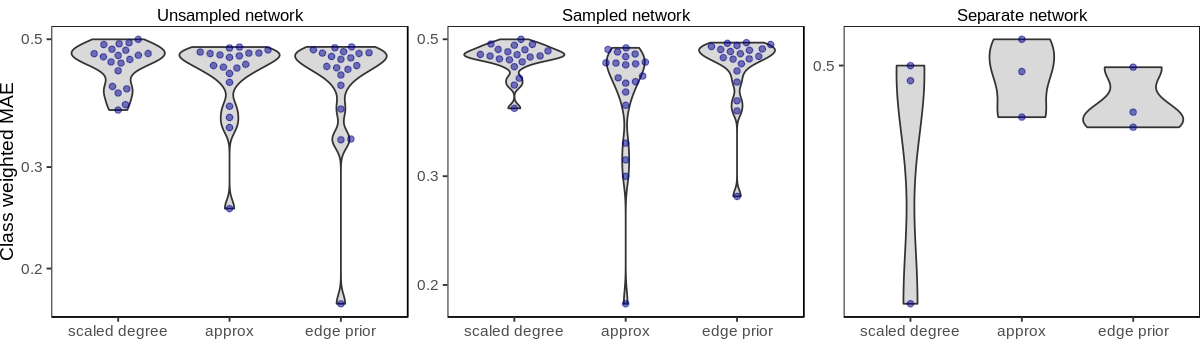

In [9]:
options(repr.plot.width=10, repr.plot.height=3)

wmae_violin <- (
    ggplot(metrics, aes(x = feature, y = weighted_mae))
    + facet_wrap(vars(network), scales = 'free_y')
#     + geom_boxplot(outlier.shape = NA)
    + geom_violin(fill = 'grey85')
    + geom_beeswarm(alpha = 0.5, color = 'darkblue', cex = 3)
    + theme_zietzm()
#     + scale_y_log10()
    + scale_y_continuous(trans = 'log10')
    + theme(plot.margin = unit(c(0.2, 0, 0, 0), "cm"))
    + xlab("") 
    + ylab("Class weighted MAE")
)

wmae_violin

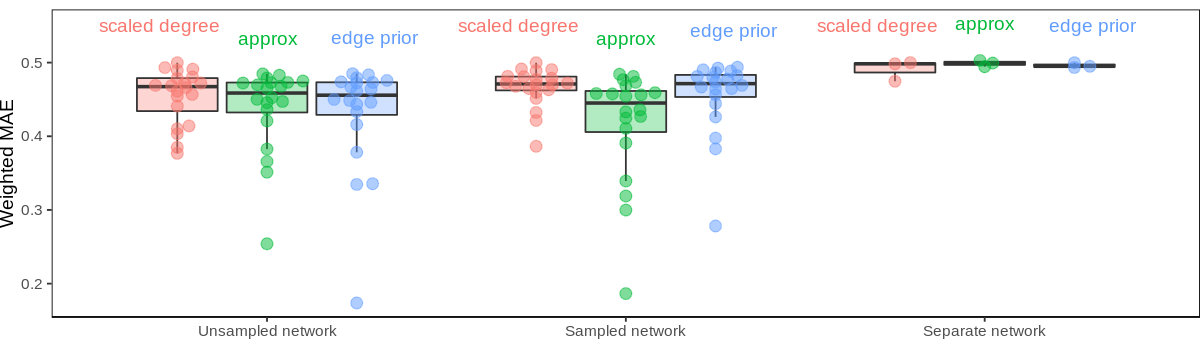

In [10]:
options(repr.plot.width=10, repr.plot.height=3)

labels_df <- metrics %>% 
    group_by(feature, network) %>% 
    top_n(weighted_mae, n = 1) %>%
    mutate(
#         y = 7e-2,
        y = 1.1 * weighted_mae
    )

wmae_3 <- (
    ggplot(metrics, aes(x = network, y = weighted_mae))
    + geom_boxplot(aes(fill = feature), outlier.shape = NA, alpha = 0.3)
    + geom_beeswarm(data = metrics, aes(color = feature, group = feature), 
                    alpha = 0.5, cex = 1.5, dodge.width = 0.75, size = 3)
    + theme_zietzm()
#     + scale_y_log10()
    + theme(plot.margin = unit(c(0.2, 0, 0, 0), "cm"))
    + xlab("") 
    + ylab("Weighted MAE")
    + geom_text(data = labels_df, aes(x = network, y = y, color = feature, label = feature),
                position = position_dodge2(width = 0.9), size = 4)
    + theme(legend.position = 'none')
)

wmae_3

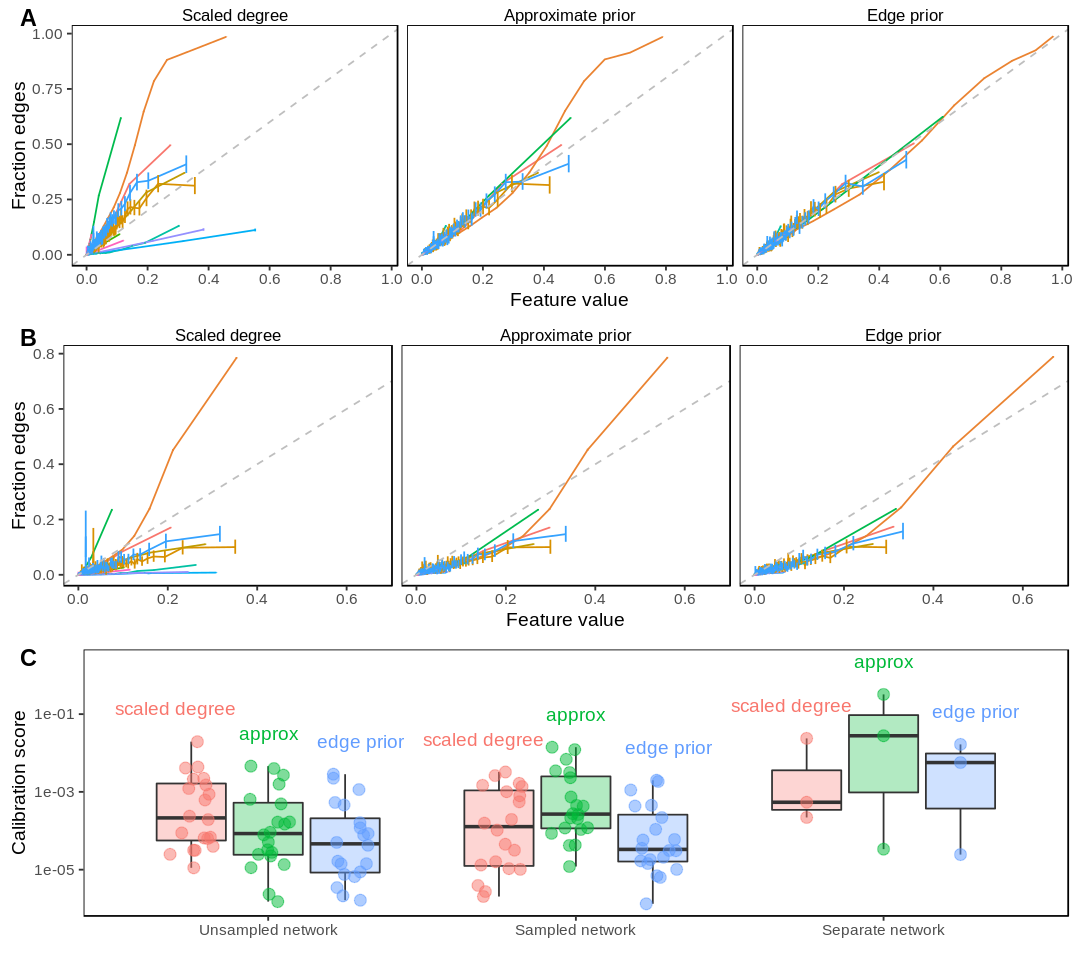

In [11]:
options(repr.plot.width=9, repr.plot.height=8)

calibration_figure <- plot_grid(
    full_calibration_plot, 
    sampled_calibration_plot, 
    cal_3, 
    ncol = 1, labels = c("A", "B", "C")) + 
    theme(plot.margin = unit(c(0, 0.25, 0, 0.25), 'cm'))

ggsave(filename = '../../img/fig4.calibration.png', plot = calibration_figure, 
       dpi = 300, width = 9, height = 8)

calibration_figure